# Imports

In [1]:
import h5py
import cv2 as cv
import numpy as np
from tqdm import tqdm
from nd2reader import ND2Reader
import matplotlib.pyplot as plt

In [2]:
def nd2ToVol(filename: str, fov: int, channel_name: str = '405 SD'):
    # volume in zyx order
    ratio = 1
    vol = ND2Reader(filename)
    channel_names = vol.metadata['channels']
    # print('Available channels:', channel_names)
    channel_id = [x for x in range(len(channel_names)) if channel_name in channel_names[x]]
    assert len(channel_id) == 1
    channel_id = channel_id[0]

    out = np.zeros([len(vol), vol[0].shape[0]//ratio , vol[0].shape[1] //ratio], np.uint16)
    for z in range(len(vol)):
        out[z] = vol.get_frame_2D(c=channel_id, t=0, z=z, x=0, y=0, v=fov)[::ratio,::ratio]
    return out

# Read volume

In [3]:
fov = 1

In [4]:
fixed_vol = nd2ToVol('/mp/nas3/ruihan/20221218_zebrafish/' + 'code{}/Channel{} SD_Seq000{}.nd2'.format(0, '405', 4), fov, '405 SD')

In [5]:
mov_vol = nd2ToVol('/mp/nas3/ruihan/20221218_zebrafish/' + 'code{}/Channel{} SD_Seq000{}.nd2'.format(2, '405', 4), fov, '405 SD')

# SIFT and FLANN

In many cases, corresponding $z$-slices are separated from one another by a large offset between the fixed and moving image volumes. This causes bias in the registration algorithms and often produces subpar results. 

To circumvent (and more importantly automate) this, one solution is to find the $z$-slice in the moving image which corresponds to the first $z$-slice of the fixed image and then crop the region between them to perform registration.

SIFT and FLANN feature descriptors allow us to perform this task automatically by means of computing a metric with a reasonable accuracy (approx. $\pm 10$ $z$-slices).

In [6]:
def computeMinFlann(fix, move, k = 1, flann_idx_kdtree = 0, flann_trees = 5, checks = 50,
                    sift_mask = None, flann_mask = False, ratio = .75):
    
    sift = cv.SIFT_create()
    index_params = dict(algorithm = flann_idx_kdtree, trees = flann_trees)
    if checks is not None:
        search_params = dict(checks=checks)   # or pass empty dictionary
    else:
        search_params = {}
        
    flann = cv.FlannBasedMatcher(index_params,search_params)
        
    _, desf = sift.detectAndCompute(fix.astype('uint8'), sift_mask)
    _, desm = sift.detectAndCompute(move.astype('uint8'), sift_mask)
        
    if desf is not None and desm is not None:
        matches = flann.knnMatch(desf, desm, k=k)
    else:
        return None
    
    dists = [pt[0].distance for pt in matches]
    dists = np.asarray(dists)
    if dists.size > 0:
        norm = np.linalg.norm(dists)
        min_dist = np.min(dists)
    else:
        return None
    
    return norm, min_dist

Since there might be multiple solution candidates (or local minima) for the corresponding $z$-slices, we compute the mutual information between the possible solutions and the first $z$-slice from the fixed volume. The slice returning maximum mutual information is heuristically our corresponding offset.

In [7]:
def mutualInformation(im1, im2, bins=20):
    hgram, _, _ = np.histogram2d(im1.ravel(), im2.ravel(), bins=bins)
    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis=1)
    py = np.sum(pxy, axis=0)
    px_py = px[:, None] * py[None, :]
    nzs = pxy > 0
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

In [8]:
def computeMaxMI(fix, mov, min_array, z_min=0, num_minima=10):
    min_sorted = np.sort(min_array)
    mi_result = dict()
    for row, min_val in enumerate(min_sorted[:num_minima]):
        z_ind = np.argwhere(min_array == min_val)[0][0] + z_min
        mov_slice = mov[z_ind,:,:]
    
        mi = mutualInformation(fix, mov_slice)
        mi_result[z_ind] = mi
        
    max_mi_ind = max(mi_result, key=mi_result.get)
    max_mi = max(mi_result.values())
    
    return max_mi, max_mi_ind

In [9]:
fix_slice = fixed_vol[0,:,:]
dists = list()

for z in tqdm(mov_vol[40:160,:,], desc='computing FLANN distance'):
    try:
        norm, dist = computeMinFlann(fix_slice, z)
        dists.append(dist)
    except:
        continue

computing FLANN distance: 100%|████████████████████████████████████████████████████████████████████████| 120/120 [05:40<00:00,  2.84s/it]


Text(0, 0.5, 'Distance')

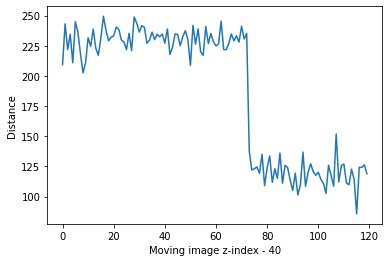

In [10]:
plt.plot(dists)
plt.xlabel('Moving image z-index - 40')
plt.ylabel('Distance')

In [11]:
max_mi, max_ind = computeMaxMI(fix_slice, mov_vol, dists, z_min = 40)

Text(0.5, 1.0, 'mov at z = 130')

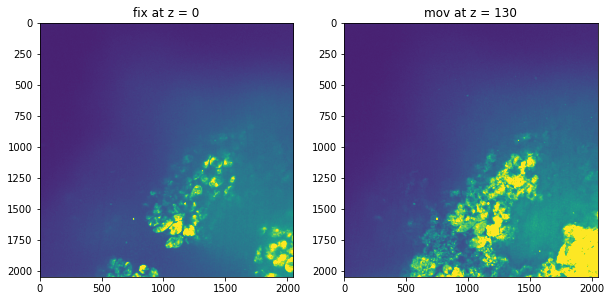

In [22]:
fig, ax = plt.subplots(1,2,figsize=(10,20))

ax[0].imshow(fixed_vol[0,:,:], vmax = 300)
ax[0].set_title('fix at z = 0')
ax[1].imshow(mov_vol[max_ind,:,:], vmax = 300)
ax[1].set_title(f'mov at z = {max_ind}')

As seem observed in the above plot, we have a very close match to the ground truth $z$-slice. It should be noted that an _actual_ ground truth slice would be very hard to find in most cases on account of rotation of the hydrogels. 

If we move within a $\pm 10$ slice vicinity of the predicted index, we find an (almost) exact match to the ground truth as illustrated in the plot below.

Text(0.5, 1.0, 'mov at z = 127')

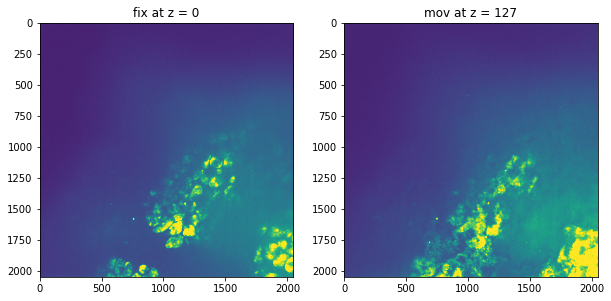

In [26]:
fig, ax = plt.subplots(1,2,figsize=(10,20))

ax[0].imshow(fixed_vol[0,:,:], vmax = 300)
ax[0].set_title('fix at z = 0')
ax[1].imshow(mov_vol[127,:,:], vmax = 300)
ax[1].set_title(f'mov at z = {127}')

'/home/ckapoor/emma'